In [65]:
import os

nb_name = "nb20230815_155800_ACh_cueonset_response_change.ipynb" #TODO change this

basename, ext = os.path.splitext(nb_name)
input_path = os.path.join(os.getcwd(), nb_name)

!jupyter nbconvert "{input_path}" --to="python" --output="{basename}"

[NbConvertApp] Converting notebook c:\Users\phar0528\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230815_155800_ACh_cueonset_response_change.ipynb to python
[NbConvertApp] Writing 29084 bytes to c:\Users\phar0528\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230815_155800_ACh_cueonset_response_change.py


based on notebooks\noncanonical\nb20230626_190400_ACh_cueonset_response_change.ipynb

based on notebooks\noncanonical\nb20230622_215600_ACh_cueonset_2_outcomes.ipynb


- animals?
- troughs for movement and reward?


- Calculate the CC and linregress slope for ACh dip, rebound, and DA peak against trial_nb
- We should be able to find sessions in which ACh rebound stays while ACh dip goes away.
- By detecting slow trough in data, we could also find sessions with recovery
- We can use `lme4` for ACh dip etc.


- scatter plots for `trial_nb` against dip size etc 
- dip size
    - selected_data = xr_photometry['hold_for_water_zscored_df_over_f'].sel(trial_nb=k, event_time=slice(150, 300))
- rebound size
    - selected_data = xr_photometry['hold_for_water_zscored_df_over_f'].sel(trial_nb=k, event_time=slice(350, 700))


\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22\TT002-2023-06-22-111549\processed

- lots of abortions


In [2]:
%reload_ext autoreload
%autoreload 2
import os
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import re
from matplotlib import pyplot as plt
import itertools
import seaborn as sns
import patchworklib as pw


from trialexp.process.pyphotometry.utils import *
from trialexp.process.pycontrol import event_filters
from trialexp.process.pycontrol.event_filters import extract_event_time
from trialexp.process.pyphotometry.utils import get_trial_numbers_for_sessions



# by_sessions_dir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions'
# task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')
# task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')
# data_dir = os.path.join(task_dir, 'TT002-2023-06-05-154932', 'processed')

# xr_photometry = xr.open_dataset(os.path.join(data_dir, 'xr_photometry.nc'))
# xr_session = xr.open_dataset(os.path.join(data_dir, 'xr_session.nc'))
# df_pycontrol = pd.read_pickle(os.path.join(data_dir, 'df_pycontrol.pkl'))
# df_events = pd.read_pickle(os.path.join(data_dir, 'df_events_cond.pkl'))


<Figure size 100x100 with 0 Axes>

In [3]:

by_sessions_dir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions'
task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')

items = os.listdir(task_dir)
data_dirs = [os.path.join(task_dir, item, 'processed') for item in items if os.path.isdir(os.path.join(task_dir, item))]
session_ids = [item for item in items if os.path.isdir(os.path.join(task_dir, item))]
subject_ids = [re.match(r"(\w+)-", ssid).group(1) for ssid in session_ids]


In [4]:
## Test data

# data_dirs = [os.path.join(
#     task_dir, 'TT002-2023-06-05-154932', 'processed')]
# session_ids = [item for item in items if os.path.isdir(os.path.join(task_dir, item))]
# subject_ids = ['TT002']


# Compute ACh
3 m 47 s for the folder 'reaching_go_spout_bar_nov22' and the 5 mice

In [5]:
subject_ids_ACh = ['TT001','TT002','TT005','RE606', 'RE607']

ind_ACh = [ind for ind, sbj in enumerate(subject_ids) if sbj in subject_ids_ACh]


In [6]:

data = []

for dd, ss, sj in zip([data_dirs[i] for i in ind_ACh], [session_ids[i] for i in ind_ACh], [subject_ids[i] for i in ind_ACh]):

    df_trials = get_trial_numbers_for_sessions(dd)
    
    n_trials = np.nan
    if isinstance(df_trials, pd.DataFrame):
        n_trials = df_trials.shape[0]
    row_data_list = [ss] + [sj] + [df_trials] + [n_trials] + [dd]
    data.append(row_data_list)

df_ACh_sessions = pd.DataFrame(data)

df_ACh_sessions.columns = ['session_id', 'subject_id', 'df_trials', 'n_trials','data_dir']


In [7]:

mask = (df_ACh_sessions['n_trials'].notnull()) & (df_ACh_sessions['n_trials'] > 100)  # more than 100 trials
df_ACh_sessions_100 = df_ACh_sessions.loc[mask]

df_ACh_sessions_100['n_trials']

1      148.0
4      155.0
5      167.0
6      327.0
7      255.0
       ...  
142    124.0
143    113.0
144    183.0
146    245.0
147    262.0
Name: n_trials, Length: 109, dtype: float64

## Plotting style

In [8]:


# Define your list of markers
markers = itertools.cycle(
    ('o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'))

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams["legend.frameon"] = False
plt.rcParams['xtick.bottom']=True
plt.rcParams['ytick.left']=True
plt.rcParams['font.family']= 'Arial'
plt.rcParams['figure.dpi']= 200


plt.rcParams['axes.labelsize'] = 16



# CC analysis of ACh


- trial_outcome
- cueonset
- spout



In [9]:
ss_d = df_ACh_sessions_100.loc[:, 'session_id']

#ss_d = df_ACh_sessions_100.loc[(df_ACh_sessions_100['trial_nb_dip_r_value'] * -1 < -0.3), 'session_id']
ss_d


1      TT002-2023-06-25-144256
4      TT002-2023-06-08-111737
5      TT002-2023-05-26-154844
6      TT001-2023-05-26-154430
7      TT002-2023-06-07-145802
                ...           
142    RE607-2023-07-20-115417
143    RE607-2023-05-24-103758
144    RE607-2023-07-18-124226
146    TT002-2023-06-22-104448
147    RE607-2023-05-30-114301
Name: session_id, Length: 109, dtype: object

In [10]:
#  Calculate CC or slope

from scipy.stats import pearsonr

if 'list_AChCC' in globals():
    del list_AChCC

list_AChCC = []
for ss in ss_d: # go round sessions

    datadir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22' + '\\' + ss + r'\processed'

    try:
        xr_photometry = xr.open_dataset(os.path.join(datadir, 'xr_photometry.nc'))
        xr_session = xr.open_dataset(os.path.join(datadir, 'xr_session.nc'))
        
        # need to select trials for success and 

        ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

        trial_nbs = xr_session['trial_nb'].values

        xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=ind_success).min(dim='event_time').values


        ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

        suc_con_dip = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=ind_success).min(dim='event_time').values
        suc_con_dip = suc_con_dip[~np.isnan(suc_con_dip)]
        suc_con_dip_r, suc_con_dip_p = pearsonr(-1 * suc_con_dip, range(1, len(suc_con_dip) +1)) # negative
        # Y could be trial_nb, range(1, len(x) +1), or timestamps of cue

        suc_con_reb = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(200, 600), trial_nb=ind_success).max(dim='event_time').values
        suc_con_reb = suc_con_reb[~np.isnan(suc_con_reb)]
        suc_con_reb_r, suc_con_reb_p = pearsonr(suc_con_reb, range(1, len(suc_con_reb) + 1))


        suc_lbo_pek = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(0, 150), trial_nb=ind_success).max(dim='event_time').values
        suc_lbo_pek = suc_lbo_pek[~np.isnan(suc_lbo_pek)]
        suc_lbo_pek_r, suc_lbo_pek_p = pearsonr(suc_lbo_pek, range(1, len(suc_lbo_pek) + 1))

        suc_lbo_tgh = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(150, 350), trial_nb=ind_success).min(dim='event_time').values 
        suc_lbo_tgh = suc_lbo_tgh[~np.isnan(suc_lbo_tgh)]
        suc_lbo_tgh_r, suc_lbo_tgh_p = pearsonr(-1 * suc_lbo_tgh, range(1, len(suc_lbo_tgh) + 1)) # negative


        suc_rew_pek = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(500, 750), trial_nb=ind_success).max(dim='event_time').values
        suc_rew_pek = suc_rew_pek[~np.isnan(suc_rew_pek)]
        suc_rew_pek_r, suc_rew_pek_p = pearsonr(suc_rew_pek, range(1, len(suc_rew_pek) + 1))

        suc_rew_tgh = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(700, 950), trial_nb=ind_success).min(dim='event_time').values 
        suc_rew_tgh = suc_rew_tgh[~np.isnan(suc_rew_tgh)]
        suc_rew_tgh_r, suc_rew_tgh_p = pearsonr(-1 * suc_rew_tgh, range(1, len(suc_rew_tgh) + 1)) # negative



        items = [ss,
                suc_con_dip, suc_con_reb, 
                suc_lbo_pek, suc_lbo_tgh,
                suc_rew_pek, suc_rew_tgh,
                suc_con_dip_r, suc_con_reb_r, 
                suc_lbo_pek_r, suc_lbo_tgh_r,
                suc_rew_pek_r, suc_rew_tgh_r]
        
    except Exception as e: 
        print(f'{ss}, {e}')
        items = [ss, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

    df_AChCC = pd.DataFrame([items])
    df_AChCC.columns = ['session_id', 
                        'suc_con_dip', 'suc_con_reb',
                        'suc_lbo_pek','suc_lbo_tgh',
                        'suc_rew_pek', 'suc_rew_tgh',
                        'suc_con_dip_r', 'suc_con_reb_r',
                        'suc_lbo_pek_r', 'suc_lbo_tgh_r', 
                        'suc_rew_pek_r', 'suc_rew_tgh_r']
    list_AChCC.append(df_AChCC)



TT001-2023-06-21-142149, x and y must have length at least 2.
RE606-2023-08-08-103906, zero-size array to reduction operation maximum which has no identity


In [32]:
df_AChCC_ = pd.concat(list_AChCC, axis=0)

df_AChCC_ = df_AChCC_.dropna(subset=['suc_con_dip_r'])

df_AChCC_['subject_id'] = [re.search('\w+', sid).group(0) for sid in df_AChCC_['session_id']]
df_AChCC_ = df_AChCC_.reset_index(drop=True)

df_AChCC_

df_AChCC__ = df_AChCC_.loc[:,  ['suc_con_dip_r', 'suc_con_reb_r', 'suc_lbo_pek_r', 'suc_lbo_tgh_r', 'suc_rew_pek_r', 'suc_rew_tgh_r', 'subject_id']]


df_ACh_melted = df_AChCC__.melt(id_vars=['subject_id'], var_name='group', value_name='value')


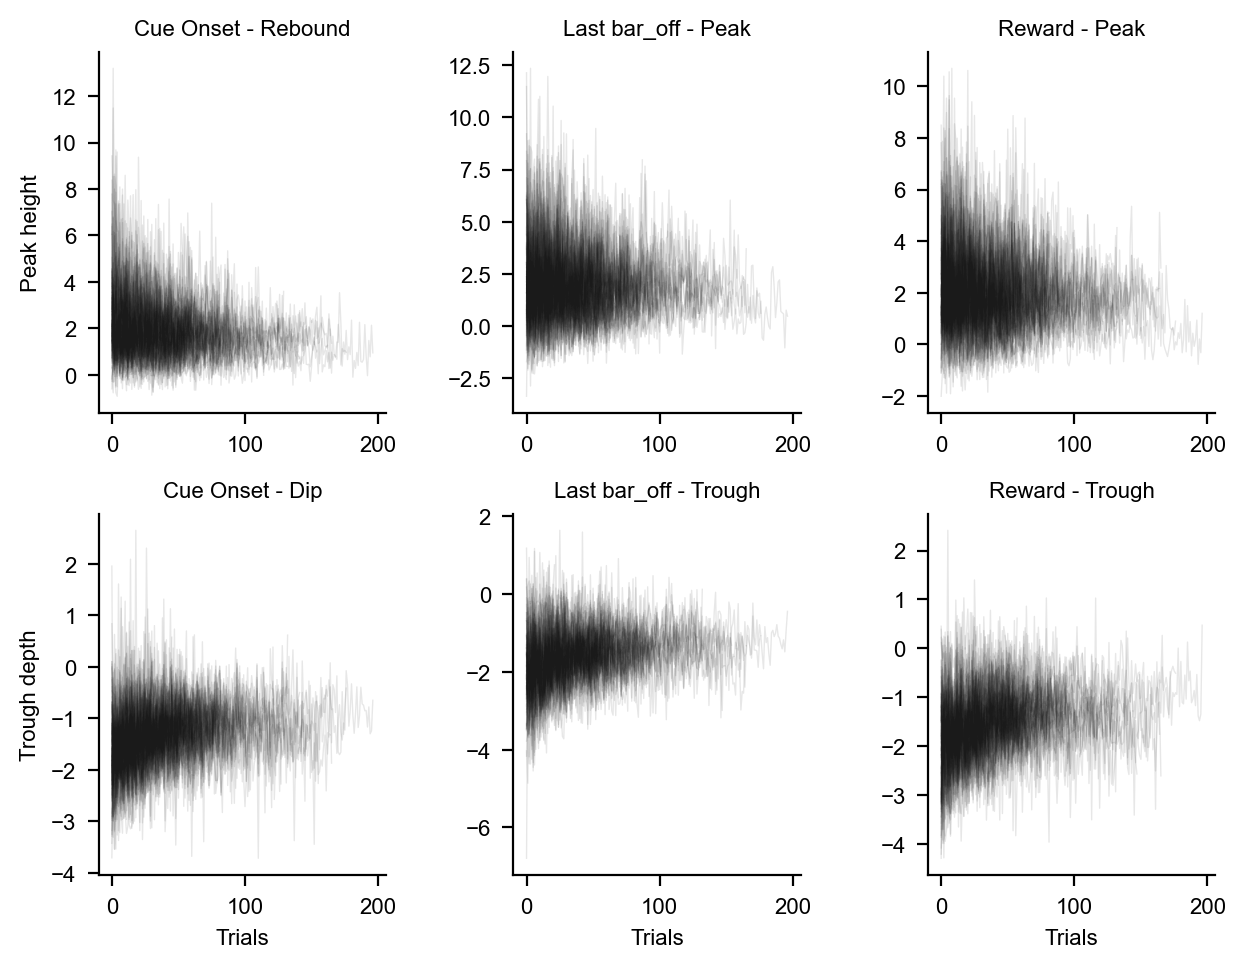

In [64]:

plt.rcParams['axes.labelsize'] = 8

fig, ax = plt.subplots(2,3)

plt.tight_layout()

plt.sca(ax[0,0])
plt.title('Cue Onset - Rebound', fontsize = 8)
for i in range(0, df_AChCC_.shape[0]):
    plt.plot(df_AChCC_.loc[i,'suc_con_reb'], color=[0.1, 0.1, 0.1], linewidth=0.5, alpha=0.1)


plt.sca(ax[1,0])
plt.title('Cue Onset - Dip', fontsize = 8)
for i in range(0, df_AChCC_.shape[0]):
    plt.plot(df_AChCC_.loc[i,'suc_con_dip'], color=[0.1, 0.1, 0.1], linewidth=0.5, alpha=0.1)


plt.sca(ax[0,1])
plt.title('Last bar_off - Peak', fontsize = 8)
for i in range(0, df_AChCC_.shape[0]):
    plt.plot(df_AChCC_.loc[i,'suc_lbo_pek'], color=[0.1, 0.1, 0.1], linewidth=0.5, alpha=0.1)

plt.sca(ax[1,1])
plt.title('Last bar_off - Trough', fontsize = 8)
for i in range(0, df_AChCC_.shape[0]):
    plt.plot(df_AChCC_.loc[i,'suc_lbo_tgh'], color=[0.1, 0.1, 0.1], linewidth=0.5, alpha=0.1)

plt.sca(ax[0,2])
plt.title('Reward - Peak', fontsize = 8)
for i in range(0, df_AChCC_.shape[0]):
    plt.plot(df_AChCC_.loc[i,'suc_rew_pek'], color=[0.1, 0.1, 0.1], linewidth=0.5, alpha=0.1)

plt.sca(ax[1,2])
plt.title('Reward - Trough', fontsize = 8)
for i in range(0, df_AChCC_.shape[0]):
    plt.plot(df_AChCC_.loc[i,'suc_rew_tgh'], color=[0.1, 0.1, 0.1], linewidth=0.5, alpha=0.1)


for j in [0, 1, 2]:
    for i in [0, 1]:
        ax[i,j].tick_params(axis='both', which='major', labelsize=8)
        if i == 0 :
            if j == 0:
                ax[i,j].set_ylabel('Peak height')
        else:
            if j ==0:
                ax[i,j].set_ylabel('Trough depth')
            ax[i,j].set_xlabel('Trials')




# ACh, correlation coefficients of response size and successful trial ordinals

In [13]:
group_counts = df_ACh_melted.groupby('group')['subject_id'].value_counts().unstack()
print(group_counts)

# Check if all columns (i.e., subject_id counts across groups) have the same values
consistent_counts = group_counts.apply(lambda col: col.nunique() == 1, axis=0)
all_consistent = consistent_counts.all()
print(f"All groups have consistent counts: {all_consistent}")


subject_id     RE606  RE607  TT001  TT002  TT005
group                                           
suc_con_dip_r     20     20     19     25     23
suc_con_reb_r     20     20     19     25     23
suc_lbo_pek_r     20     20     19     25     23
suc_lbo_tgh_r     20     20     19     25     23
suc_rew_pek_r     20     20     19     25     23
suc_rew_tgh_r     20     20     19     25     23
All groups have consistent counts: True


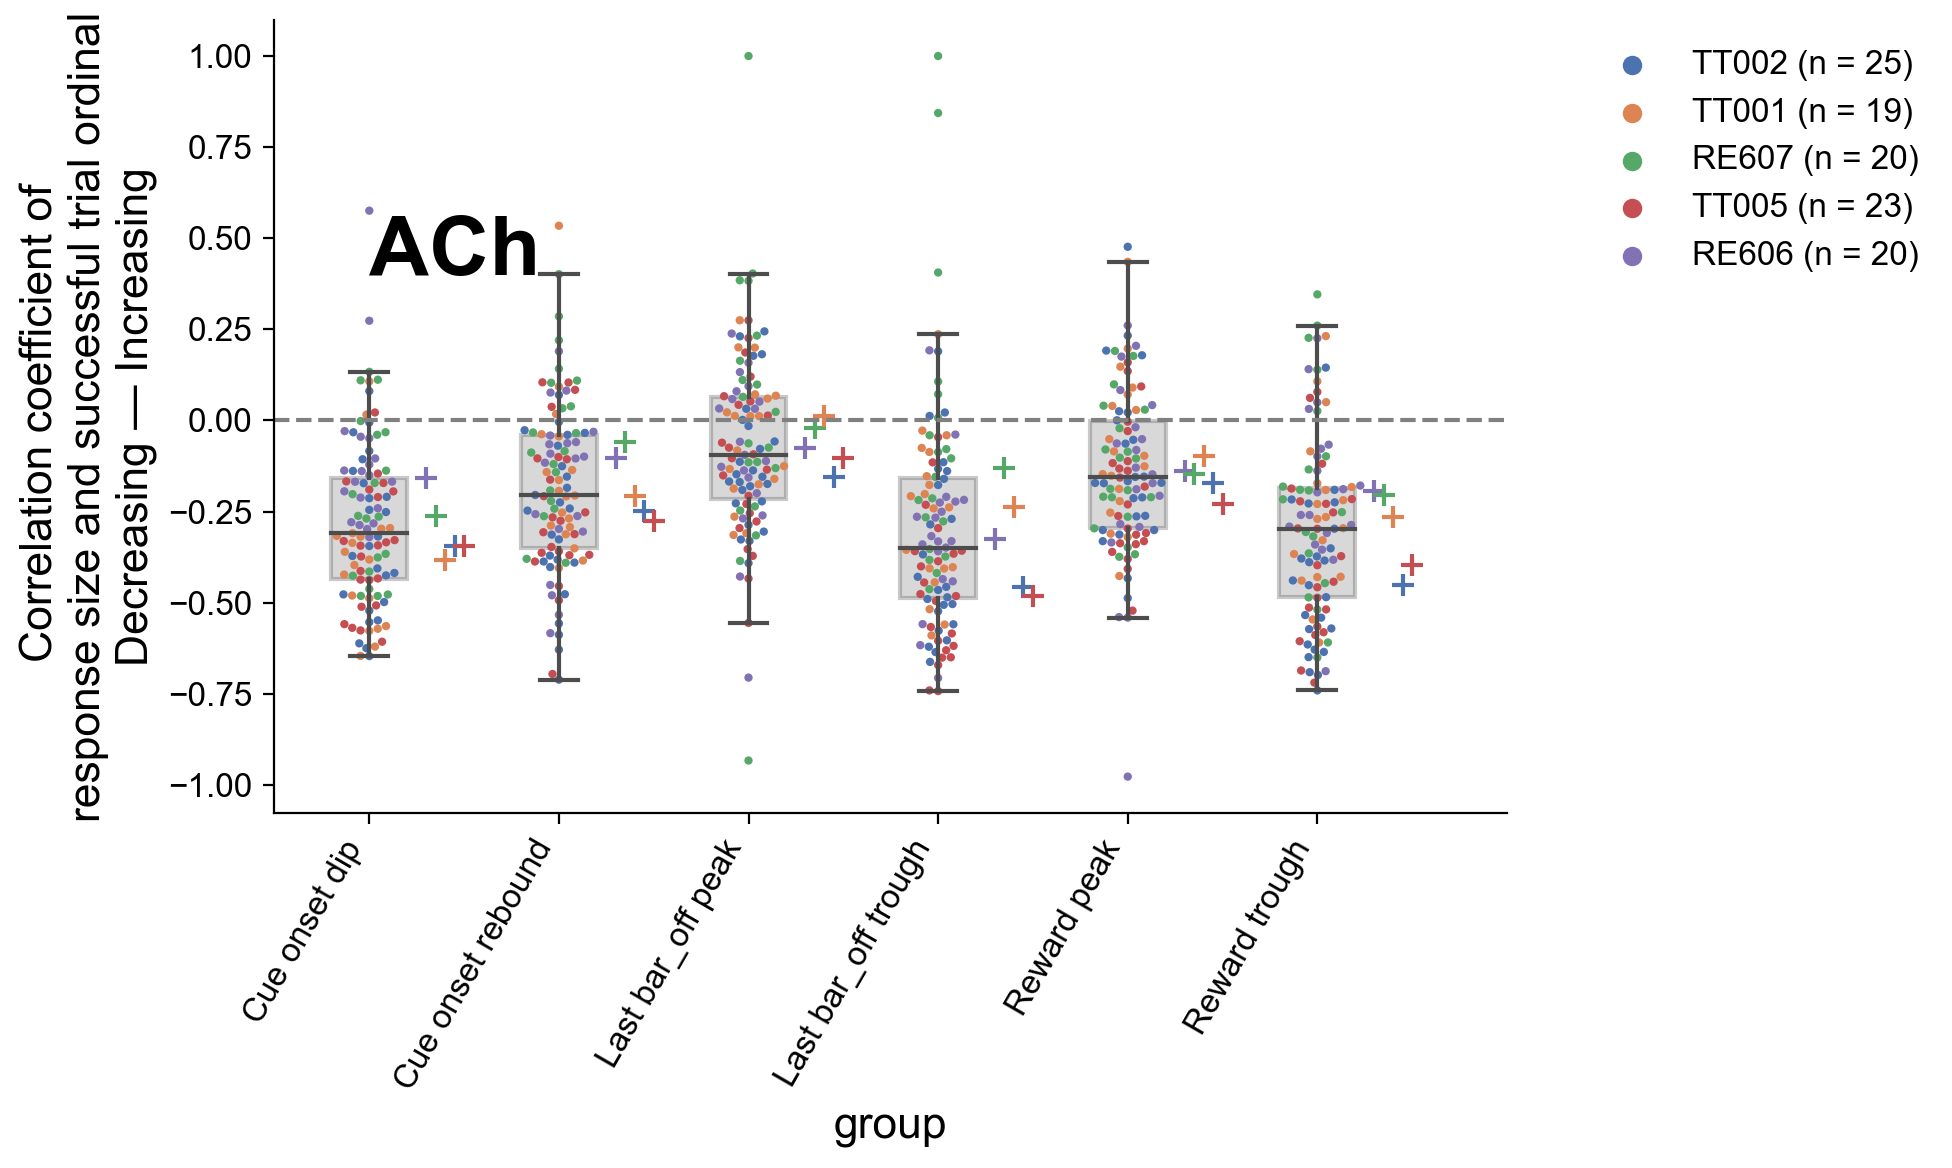

In [14]:
subject_counts = group_counts.loc['suc_con_dip_r'].to_dict()


unique_subjects = df_ACh_melted['subject_id'].unique()
palette = sns.color_palette('deep', n_colors=len(unique_subjects))
color_mapping = dict(zip(unique_subjects, palette))
color_mapping_with_counts = {f"{subj} (n = {count})": color_mapping[subj] for subj, count in subject_counts.items()}

# add new column for subject_id with sample size
df_DA_melted['subject_id_with_count'] = df_ACh_melted['subject_id'].apply(lambda x: f"{x} (n = {subject_counts[x]})")

medians = df_ACh_melted.groupby(['group', 'subject_id']).median().reset_index()

plt.figure(figsize=(10, 6))
sns.swarmplot(x='group', y='value', data=df_ACh_melted, hue='subject_id_with_count',
              zorder=1, palette=color_mapping_with_counts, size=3)  # zorder=1 to be underneath the boxplot
# zorder=2 to be over the swarmplot
sns.boxplot(x='group', y='value', data=df_ACh_melted, zorder=2,
            boxprops=dict(alpha=.3), width=0.4, color='gray', showfliers=False)

# Plot medians
offset_center = 0.4
offset_interval = 0.05
number_of_offsets = 5

offsets = np.linspace(offset_center - (number_of_offsets - 1) / 2 * offset_interval,
                      offset_center + (number_of_offsets - 1) / 2 * offset_interval,
                      number_of_offsets)

group_order = ['suc_con_dip_r', 'suc_con_reb_r', 'suc_lbo_pek_r', 'suc_lbo_tgh_r', 'suc_rew_pek_r', 'suc_rew_tgh_r']  # Order of the groups

for i, group in enumerate(group_order):
    group_medians = medians[medians['group'] == group]
    # for offset, (subj, row) in zip(offsets, group_medians.iterrows()):
    #     plt.scatter(i + offset, row['value'], s=40, color=color_mapping_with_counts[row['subject_id_with_count']], label=row['subject_id_with_count'])
    for offset, (subj, row) in zip(offsets, group_medians.iterrows()):
        subject_id_with_count = f"{row['subject_id']} (n = {subject_counts[row['subject_id']]})"
        plt.scatter(i + offset, row['value'], s=60, marker='+',color=color_mapping_with_counts[subject_id_with_count], label=subject_id_with_count)


plt.axhline(0, ls='--', color='gray')
plt.ylabel('Correlation coefficient of \nresponse size and successful trial ordinal\nDecreasing — Increasing')
plt.xticks(range(0, 6), ['Cue onset dip', 'Cue onset rebound',
           'Last bar_off peak','Last bar_off trough', 'Reward peak', 'Reward trough'], rotation=60, ha='right')
plt.text(0, 0.40, 'ACh',fontsize=30, fontweight='bold')
plt.xlim(-0.5, 6)

# make the legend pretty


# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Remove duplicates (as scatter plot might have created multiple entries for the same legend)
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create a new legend
plt.legend(unique_handles, unique_labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust subplot parameters to make the plot fit the figure area
plt.show()


It's better to identify outliers and understand what's going wrong.
And then remove them accordingly.

# without outliers

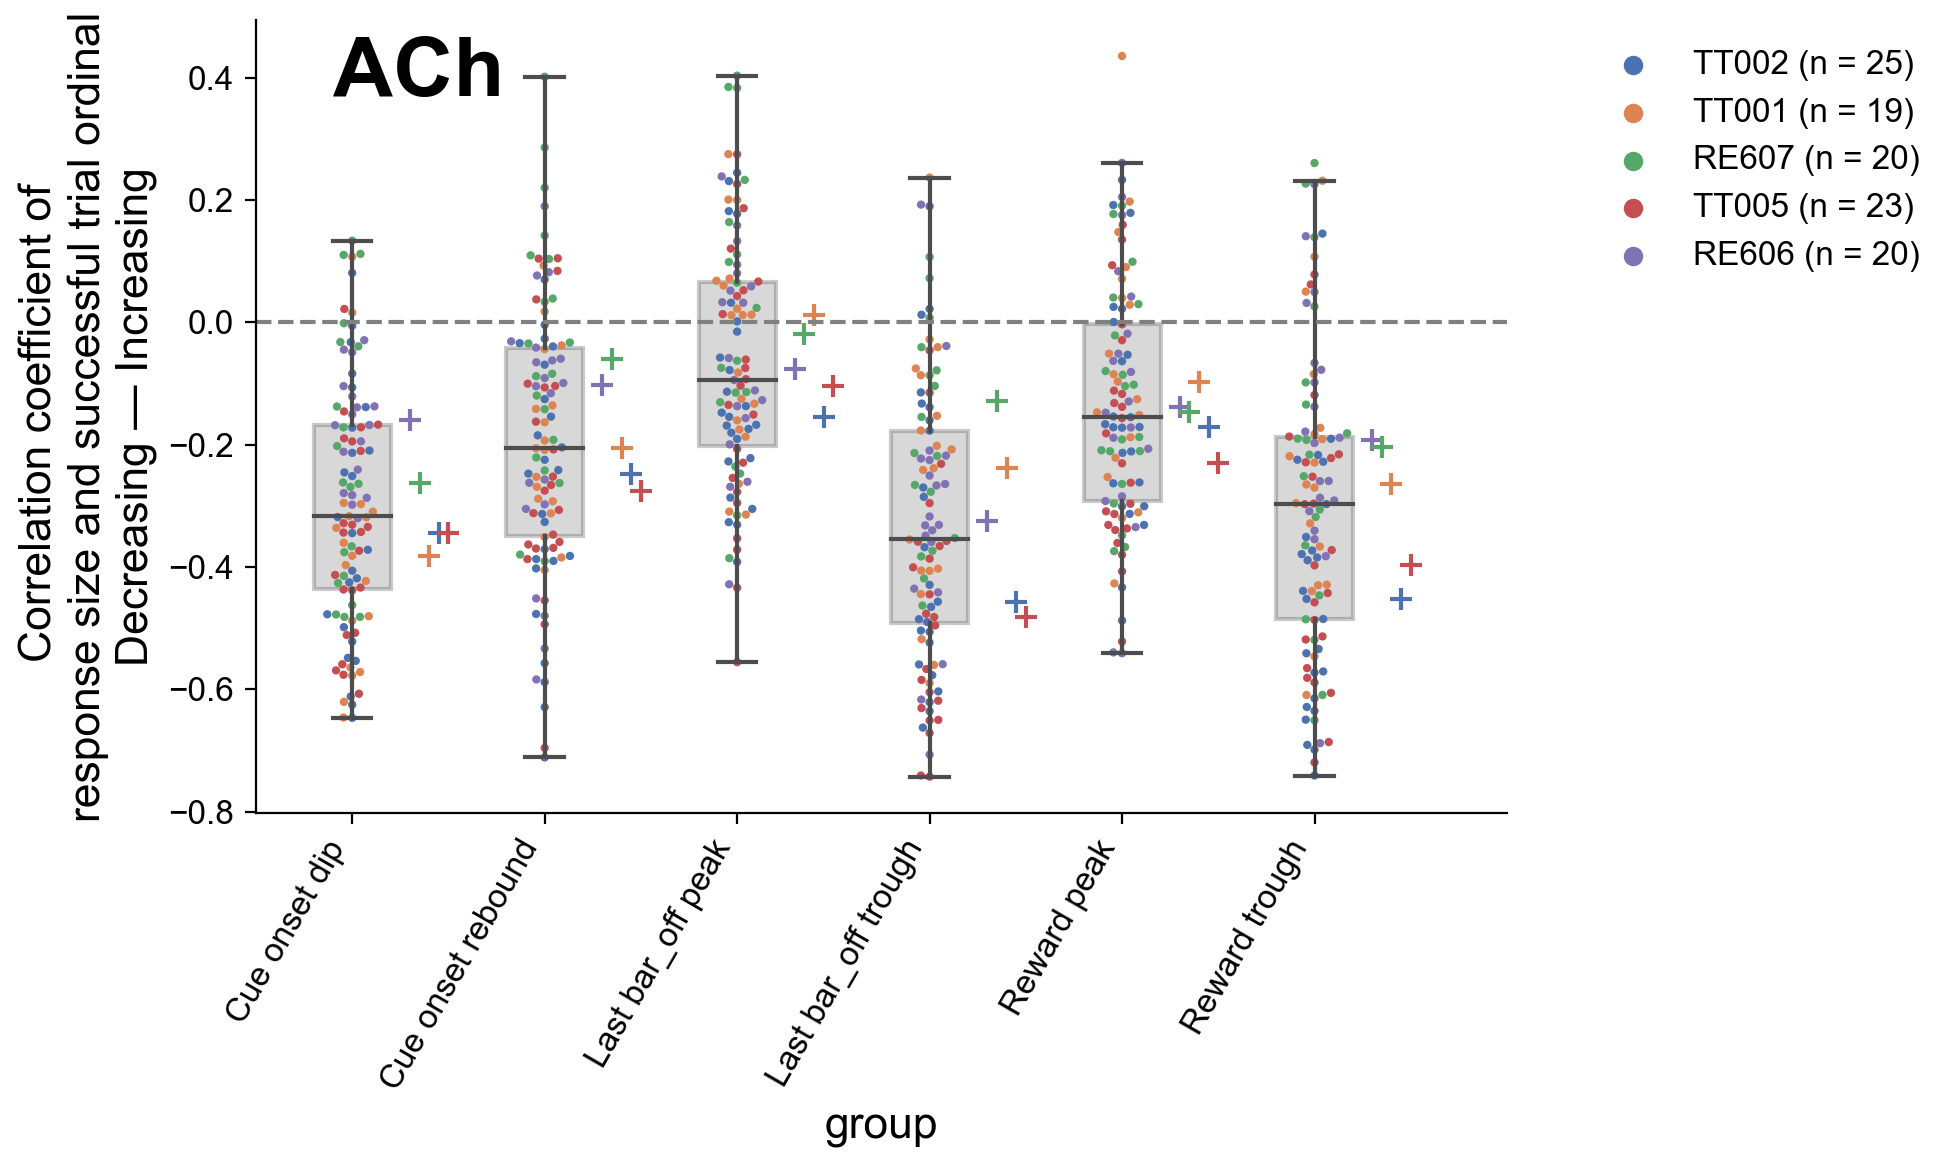

In [21]:
# hide a few outliers

Q1 = df_ACh_melted.groupby('group')['value'].quantile(0.25)
Q3 = df_ACh_melted.groupby('group')['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# This function will return True for outliers and False for valid data points
def is_outlier(row):
    group = row['group']
    return (row['value'] < lower_bound[group]) or (row['value'] > upper_bound[group])

# Add a new column to indicate outliers
df_ACh_melted['is_outlier'] = df_ACh_melted.apply(is_outlier, axis=1)

# Filter out outliers
df_ACh_filtered = df_ACh_melted[~df_ACh_melted['is_outlier']]



subject_counts = group_counts.loc['suc_con_dip_r'].to_dict()


unique_subjects = df_ACh_melted['subject_id'].unique()
palette = sns.color_palette('deep', n_colors=len(unique_subjects))
color_mapping = dict(zip(unique_subjects, palette))
color_mapping_with_counts = {f"{subj} (n = {count})": color_mapping[subj] for subj, count in subject_counts.items()}

# add new column for subject_id with sample size
df_ACh_melted['subject_id_with_count'] = df_ACh_melted['subject_id'].apply(lambda x: f"{x} (n = {subject_counts[x]})")

medians = df_ACh_melted.groupby(['group', 'subject_id']).median().reset_index()

plt.figure(figsize=(10, 6))
sns.swarmplot(x='group', y='value', data=df_ACh_filtered, hue='subject_id_with_count',
              zorder=1, palette=color_mapping_with_counts, size=3)  # zorder=1 to be underneath the boxplot
# zorder=2 to be over the swarmplot
sns.boxplot(x='group', y='value', data=df_ACh_filtered, zorder=2,
            boxprops=dict(alpha=.3), width=0.4, color='gray', showfliers=False)

# Plot medians
offset_center = 0.4
offset_interval = 0.05
number_of_offsets = 5

offsets = np.linspace(offset_center - (number_of_offsets - 1) / 2 * offset_interval,
                      offset_center + (number_of_offsets - 1) / 2 * offset_interval,
                      number_of_offsets)

group_order = ['suc_con_dip_r', 'suc_con_reb_r', 'suc_lbo_pek_r', 'suc_lbo_tgh_r', 'suc_rew_pek_r', 'suc_rew_tgh_r']  # Order of the groups

for i, group in enumerate(group_order):
    group_medians = medians[medians['group'] == group]
    # for offset, (subj, row) in zip(offsets, group_medians.iterrows()):
    #     plt.scatter(i + offset, row['value'], s=40, color=color_mapping_with_counts[row['subject_id_with_count']], label=row['subject_id_with_count'])
    for offset, (subj, row) in zip(offsets, group_medians.iterrows()):
        subject_id_with_count = f"{row['subject_id']} (n = {subject_counts[row['subject_id']]})"
        plt.scatter(i + offset, row['value'], s=60, marker='+',color=color_mapping_with_counts[subject_id_with_count], label=subject_id_with_count)


plt.axhline(0, ls='--', color='gray')
plt.ylabel('Correlation coefficient of \nresponse size and successful trial ordinal\nDecreasing — Increasing')
plt.xticks(range(0, 6), ['Cue onset dip', 'Cue onset rebound',
           'Last bar_off peak','Last bar_off trough', 'Reward peak', 'Reward trough'], rotation=60, ha='right')
plt.text(-0.1, 0.37, 'ACh',fontsize=30, fontweight='bold')
plt.xlim(-0.5, 6)

# make the legend pretty


# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Remove duplicates (as scatter plot might have created multiple entries for the same legend)
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create a new legend
plt.legend(unique_handles, unique_labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust subplot parameters to make the plot fit the figure area
plt.show()


# Compute DA


In [22]:
subject_ids_DA = ['kms058','kms062','kms063','kms064', 'JC317L']

ind_DA = [ind for ind, sbj in enumerate(subject_ids) if sbj in subject_ids_DA]


In [23]:
data = []

for dd, ss, sj in zip([data_dirs[i] for i in ind_DA], [session_ids[i] for i in ind_DA], [subject_ids[i] for i in ind_DA]):

    df_trials = get_trial_numbers_for_sessions(dd)
    
    n_trials = np.nan
    if isinstance(df_trials, pd.DataFrame):
        n_trials = df_trials.shape[0]
    row_data_list = [ss] + [sj] + [df_trials] + [n_trials] + [dd]
    data.append(row_data_list)

df_DA_sessions = pd.DataFrame(data)

df_DA_sessions.columns = ['session_id', 'subject_id', 'df_trials', 'n_trials','data_dir']


In [24]:
mask = (df_DA_sessions['n_trials'].notnull()) & (df_DA_sessions['n_trials'] > 100)  # more than 100 trials & is_success
df_DA_sessions_100 = df_DA_sessions.loc[mask]

df_DA_sessions_100['n_trials']

0      169.0
1      173.0
3      193.0
4      273.0
5      193.0
       ...  
137    199.0
138    212.0
140    156.0
142    196.0
143    164.0
Name: n_trials, Length: 83, dtype: float64

In [25]:
dass_d = df_DA_sessions_100.loc[:, 'session_id']

#ss_d = df_ACh_sessions_100.loc[(df_ACh_sessions_100['trial_nb_dip_r_value'] * -1 < -0.3), 'session_id']
dass_d


0      kms064-2023-02-20-101308
1      kms062-2023-02-13-110211
3      kms062-2023-02-09-100252
4      kms064-2023-03-03-102930
5      kms064-2023-02-07-102029
                 ...           
137    kms058-2023-03-13-101915
138    kms058-2023-02-23-163236
140    kms058-2023-02-21-115213
142    kms058-2023-02-22-162147
143    kms063-2023-03-03-095836
Name: session_id, Length: 83, dtype: object

In [26]:
#  Calculate CC or slope

from scipy.stats import pearsonr

if 'list_DACC' in globals():
    del list_DACC

list_DACC = []
for ss in dass_d: # go round sessions

    datadir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22' + '\\' + ss + r'\processed'

    try:
        xr_photometry = xr.open_dataset(os.path.join(datadir, 'xr_photometry.nc'))
        xr_session = xr.open_dataset(os.path.join(datadir, 'xr_session.nc'))
        
        # need to select trials for success and 

        ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

        trial_nbs = xr_session['trial_nb'].values

        ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1


        suc_con_pek = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=ind_success).max(dim='event_time').values
        suc_con_pek = suc_con_pek[~np.isnan(suc_con_pek)]
        suc_con_pek_r, suc_con_pek_p = pearsonr(suc_con_pek, range(1, len(suc_con_pek) + 1))


        suc_lbo_pek = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(50, 300), trial_nb=ind_success).max(dim='event_time').values
        suc_lbo_pek = suc_lbo_pek[~np.isnan(suc_lbo_pek)]
        suc_lbo_pek_r, suc_lbo_pek_p = pearsonr(suc_lbo_pek, range(1, len(suc_lbo_pek) + 1))



        suc_rew_pek = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(550, 800), trial_nb=ind_success).max(dim='event_time').values
        suc_rew_pek = suc_rew_pek[~np.isnan(suc_rew_pek)]
        suc_rew_pek_r, suc_rew_pek_p = pearsonr(suc_rew_pek, range(1, len(suc_rew_pek) + 1))


        items = [ss,
                suc_con_pek, 
                suc_lbo_pek,
                suc_rew_pek,
                suc_con_pek_r, 
                suc_lbo_pek_r,
                suc_rew_pek_r]
        
    except Exception as e: 
        print(f'{ss}, {e}')
        items = [ss, np.nan, np.nan, np.nan,
                np.nan, np.nan, np.nan, ]

    df_DACC = pd.DataFrame([items])
    df_DACC.columns = ['session_id',
                        'suc_con_pek',
                        'suc_lbo_pek',
                        'suc_rew_pek', 
                        'suc_con_pek_r',
                        'suc_lbo_pek_r', 
                        'suc_rew_pek_r']
    list_DACC.append(df_DACC)



kms064-2023-03-03-102930, 'hold_for_water_zscored_df_over_f'


In [27]:
df_DACC_ = pd.concat(list_DACC, axis=0)

df_DACC_ = df_DACC_.dropna(subset=['suc_con_pek'])

df_DACC_['subject_id'] = [re.search('\w+', sid).group(0) for sid in df_DACC_['session_id']]
df_DACC_


,session_id,suc_con_pek,suc_lbo_pek,suc_rew_pek,suc_con_pek_r,suc_lbo_pek_r,suc_rew_pek_r,subject_id
0,kms064-2023-02-20-101308,"[3.206225037185754, 1.1545181362011547, 1.1591...","[0.10268854041935574, -0.28346335592484917, 0....","[2.500605981642153, 6.34236073549434, 4.240997...",-0.448296,0.422629,-0.436367,kms064
0,kms062-2023-02-13-110211,"[-1.1118558152489646, 0.03786338444918274, -0....","[2.339377572990462, 2.343634245069493, 4.55290...","[1.0634502923059854, 0.13511306813559407, -0.0...",0.045236,-0.078442,0.290332,kms062
0,kms062-2023-02-09-100252,"[-0.19753521709940072, -0.7957628220388558, 0....","[5.964084923963585, 3.9899556952737605, -0.388...","[1.789278803368875, 0.941626533859433, 3.15678...",-0.244816,-0.082778,0.297574,kms062
0,kms064-2023-02-07-102029,"[1.7735933222492475, 1.8927477572815503, 2.210...","[2.6373743441830406, 3.937607526264445, 2.5589...","[2.0878594198809135, 0.9115097604148943, 2.761...",-0.231692,-0.072405,-0.168161,kms064
0,kms063-2023-03-23-110539,"[0.4404177436222679, -0.27961062749989696, 0.4...","[4.1009273216606035, 6.751962413498145, 1.7500...","[1.8915428547692932, 1.8050732098917759, 0.575...",0.479210,-0.117926,0.640759,kms063
...,...,...,...,...,...,...,...,...
0,kms058-2023-03-13-101915,"[3.2183502651552955, 5.650285589500588, 5.2463...","[1.7268621999013205, 2.7160966738608403, 1.301...","[7.817174139904989, 6.504103043418148, 4.60168...",-0.524252,0.165129,-0.527763,kms058
0,kms058-2023-02-23-163236,"[3.5772041481697334, 0.5924218676568731, 3.713...","[1.902698196947353, 1.7788088531718247, -0.305...","[8.32535297866058, 2.528310764560891, 4.755300...",0.102668,0.330317,-0.097607,kms058
0,kms058-2023-02-21-115213,"[2.4450658343305847, 2.762175832595721, 3.1601...","[5.898995263094418, 1.0047686969008354, 3.9992...","[2.4491599013733842, 1.0112287709920125, 7.486...",0.165707,0.071374,0.039866,kms058
0,kms058-2023-02-22-162147,"[2.5576940461007767, 3.983545996513288, 3.5162...","[1.822828053496942, 3.0095523091349023, 1.2915...","[4.053554927537181, 1.9611807761009201, 1.9564...",-0.099810,0.060764,0.120926,kms058


In [28]:
df_DACC__ = df_DACC_.loc[:,  ['suc_con_pek_r', 'suc_lbo_pek_r', 'suc_rew_pek_r', 'subject_id']]

df_DA_melted = df_DACC__.melt(id_vars=['subject_id'], var_name='group', value_name='value')


In [29]:
group_counts = df_DA_melted.groupby('group')['subject_id'].value_counts().unstack()
print(group_counts)

# Check if all columns (i.e., subject_id counts across groups) have the same values
consistent_counts = group_counts.apply(lambda col: col.nunique() == 1, axis=0)
all_consistent = consistent_counts.all()
print(f"All groups have consistent counts: {all_consistent}")

subject_id     JC317L  kms058  kms062  kms063  kms064
group                                                
suc_con_pek_r       4      20      18      26      14
suc_lbo_pek_r       4      20      18      26      14
suc_rew_pek_r       4      20      18      26      14
All groups have consistent counts: True


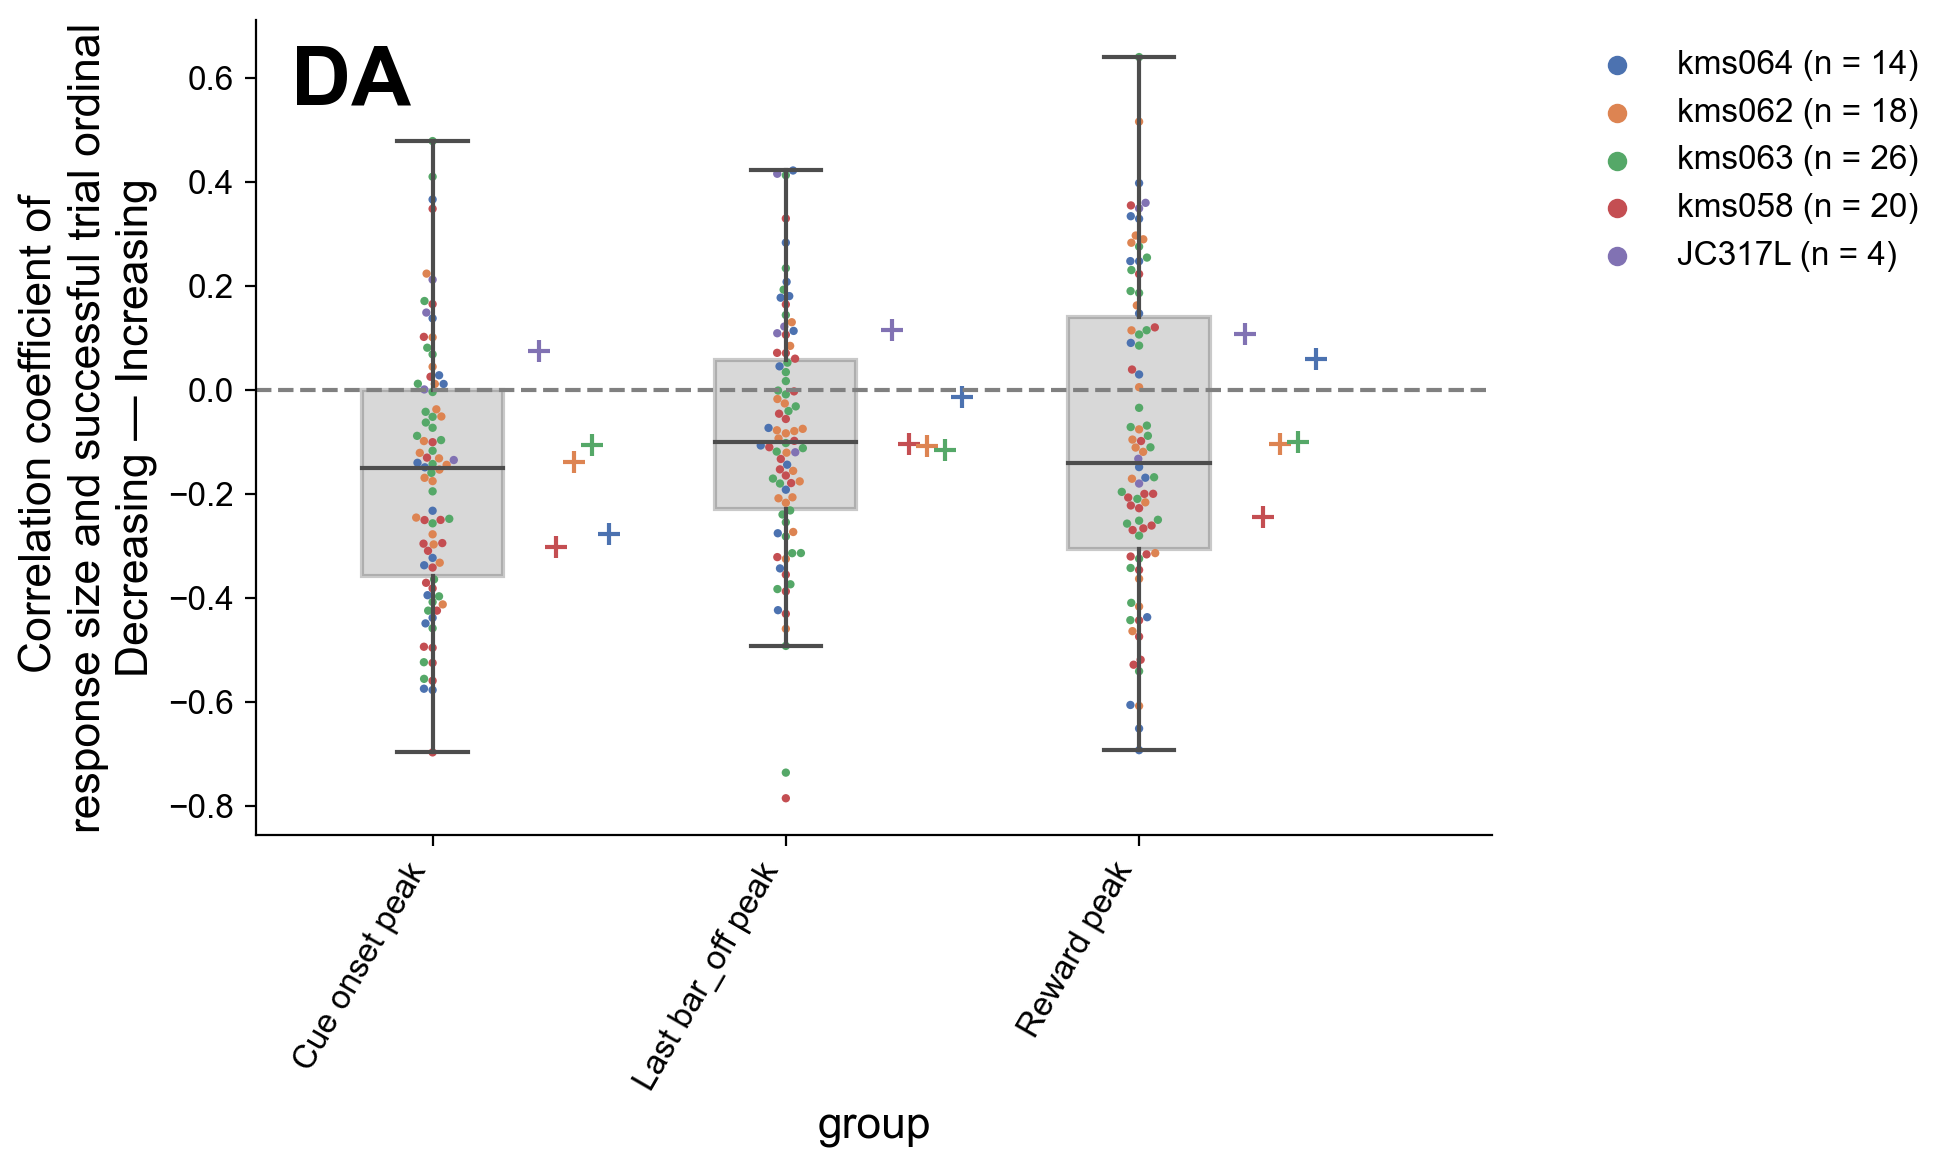

In [30]:
subject_counts = group_counts.loc['suc_con_pek_r'].to_dict()


unique_subjects = df_DA_melted['subject_id'].unique()
palette = sns.color_palette('deep', n_colors=len(unique_subjects))
color_mapping = dict(zip(unique_subjects, palette))
color_mapping_with_counts = {f"{subj} (n = {count})": color_mapping[subj] for subj, count in subject_counts.items()}

# add new column for subject_id with sample size
df_DA_melted['subject_id_with_count'] = df_DA_melted['subject_id'].apply(lambda x: f"{x} (n = {subject_counts[x]})")

medians = df_DA_melted.groupby(['group', 'subject_id']).median().reset_index()

plt.figure(figsize=(10, 6))
sns.swarmplot(x='group', y='value', data=df_DA_melted, hue='subject_id_with_count',
              zorder=1, palette=color_mapping_with_counts, size=3)  # zorder=1 to be underneath the boxplot
# zorder=2 to be over the swarmplot
sns.boxplot(x='group', y='value', data=df_DA_melted, zorder=2,
            boxprops=dict(alpha=.3), width=0.4, color='gray', showfliers=False)

# Plot medians
offset_center = 0.4
offset_interval = 0.05
number_of_offsets = 5

offsets = np.linspace(offset_center - (number_of_offsets - 1) / 2 * offset_interval,
                      offset_center + (number_of_offsets - 1) / 2 * offset_interval,
                      number_of_offsets)

group_order = ['suc_con_pek_r', 'suc_lbo_pek_r',  'suc_rew_pek_r']  # Order of the groups

for i, group in enumerate(group_order):
    group_medians = medians[medians['group'] == group]
    for offset, (subj, row) in zip(offsets, group_medians.iterrows()):
        subject_id_with_count = f"{row['subject_id']} (n = {subject_counts[row['subject_id']]})"
        plt.scatter(i + offset, row['value'], s=60, marker='+',color=color_mapping_with_counts[subject_id_with_count], label=subject_id_with_count)


plt.axhline(0, ls='--', color='gray')
plt.ylabel('Correlation coefficient of \nresponse size and successful trial ordinal\nDecreasing — Increasing')
plt.xticks(range(0, 3), ['Cue onset peak', 'Last bar_off peak', 'Reward peak'], rotation=60, ha='right')
plt.text(-0.4, 0.55, 'DA',fontsize=30, fontweight='bold')
plt.xlim(-0.5, 3)

# make the legend pretty


# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Remove duplicates (as scatter plot might have created multiple entries for the same legend)
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create a new legend
plt.legend(unique_handles, unique_labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust subplot parameters to make the plot fit the figure area
plt.show()


In [ ]:
# hide a few outliers

Q1 = df_DA_melted.groupby('group')['value'].quantile(0.25)
Q3 = df_DA_melted.groupby('group')['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# This function will return True for outliers and False for valid data points
def is_outlier(row):
    group = row['group']
    return (row['value'] < lower_bound[group]) or (row['value'] > upper_bound[group])

# Add a new column to indicate outliers
df_DA_melted['is_outlier'] = df_DA_melted.apply(is_outlier, axis=1)

# Filter out outliers
df_DA_filtered = df_DA_melted[~df_DA_melted['is_outlier']]



subject_counts = group_counts.loc['suc_con_dip_r'].to_dict()



unique_subjects = df_DA_melted['subject_id'].unique()
palette = sns.color_palette('deep', n_colors=len(unique_subjects))
color_mapping = dict(zip(unique_subjects, palette))
color_mapping_with_counts = {f"{subj} (n = {count})": color_mapping[subj] for subj, count in subject_counts.items()}

# add new column for subject_id with sample size
df_DA_filtered['subject_id_with_count'] = df_DA_filtered['subject_id'].apply(lambda x: f"{x} (n = {subject_counts[x]})")

medians = df_DA_filtered.groupby(['group', 'subject_id']).median().reset_index()

plt.figure(figsize=(10, 6))
sns.swarmplot(x='group', y='value', data=df_DA_filtered, hue='subject_id_with_count',
              zorder=1, palette=color_mapping_with_counts, size=3)  # zorder=1 to be underneath the boxplot
# zorder=2 to be over the swarmplot
sns.boxplot(x='group', y='value', data=df_DA_filtered, zorder=2,
            boxprops=dict(alpha=.3), width=0.4, color='gray', showfliers=False)

# Plot medians
offset_center = 0.4
offset_interval = 0.05
number_of_offsets = 5

offsets = np.linspace(offset_center - (number_of_offsets - 1) / 2 * offset_interval,
                      offset_center + (number_of_offsets - 1) / 2 * offset_interval,
                      number_of_offsets)

group_order = ['suc_con_pek_r', 'suc_lbo_pek_r',  'suc_rew_pek_r']  # Order of the groups

for i, group in enumerate(group_order):
    group_medians = medians[medians['group'] == group]
    for offset, (subj, row) in zip(offsets, group_medians.iterrows()):
        subject_id_with_count = f"{row['subject_id']} (n = {subject_counts[row['subject_id']]})"
        plt.scatter(i + offset, row['value'], s=60, marker='+',color=color_mapping_with_counts[subject_id_with_count], label=subject_id_with_count)


plt.axhline(0, ls='--', color='gray')
plt.ylabel('Correlation coefficient of \nresponse size and successful trial ordinal\nDecreasing — Increasing')
plt.xticks(range(0, 6), ['Cue onset dip', 'Cue onset rebound',
           'Last bar_off peak','Last bar_off trough', 'Reward peak', 'Reward trough'], rotation=60, ha='right')
plt.text(-0.1, 0.37, 'ACh',fontsize=30, fontweight='bold')
plt.xlim(-0.5, 6)

# make the legend pretty


# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Remove duplicates (as scatter plot might have created multiple entries for the same legend)
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create a new legend
plt.legend(unique_handles, unique_labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust subplot parameters to make the plot fit the figure area
plt.show()